# Evaluation in Numbers

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
)

from src.const.maps import EMOTION_MAP
from src.const.paths import (
    DATA_PATHS,
    MODELS_DIR,
    SPLIT_CSV,
)
from src.models.evaluate import evaluate_models
from src.models.trainer import EmotionClassifier

2026-01-25 23:48:33.889067: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-25 23:48:33.927543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-25 23:48:34.732291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
CKPT_FROZEN = MODELS_DIR / "mobilenet_v3_frozen.ckpt"
CKPT_UNFROZEN = MODELS_DIR / "mobilenet_v3_unfrozen.ckpt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data and Models

In [3]:
df_master = pd.read_csv(SPLIT_CSV)
df_test = df_master[df_master["split"] == "test"].copy()

print(f"Images in test set: {len(df_test)}")
print(f"Unique subjects in test set: {df_test['subject_id'].unique()}")

Images in test set: 377
Unique subjects in test set: ['F01' 'F05' 'F10' 'F13' 'F31' 'M01' 'M15' 'M24' 'M28']


In [4]:
model_frozen = EmotionClassifier.load_from_checkpoint(CKPT_FROZEN)
model_frozen.to(device)
model_frozen.eval()

model_unfrozen = EmotionClassifier.load_from_checkpoint(CKPT_UNFROZEN)
model_unfrozen.to(device)
model_unfrozen.eval()

INFO: Backbone frozen. Training classifier head only.


## Evaluate

In [15]:
df_test['relative_path'] = df_test['relative_path'].apply(lambda x: '/'.join(x.split("\\")))

In [ ]:
res_df = evaluate_models(
    df_test,
    device,
    model_frozen,
    model_unfrozen,
)
res_df.to_csv("outputs/evaluation_results.csv", index=False)

## Metrics over Models and Data Types

In [30]:
def get_pos(filename):
    if filename[-5] == 'S':
        return "Straight"
    elif filename[-6:-4] == 'HL':
        return "Half left"
    elif filename[-6:-4] == 'HR':
        return "Half right"
    else:
        return "Unknown"

In [35]:
res_df['angle'] = res_df['file'].apply(get_pos)


In [51]:
def plot_angle_bias(df, model_col):
    bias_df = (
        df.groupby(["domain", "angle"])
        .apply(lambda x: f1_score(x["true_idx"], x[model_col], average="macro"))
        .reset_index(name="F1-Score")
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=bias_df, 
        x="domain", 
        y="F1-Score", 
        hue="angle", 
        palette="pastel",
        order=["Original", "Grayscale", "Degraded"],
        hue_order=["Half left", "Straight","Half right"]
    )
    plt.title(f"Angle Bias Analysis: {model_col}")
    plt.ylim(0, 1.0)
    plt.show()

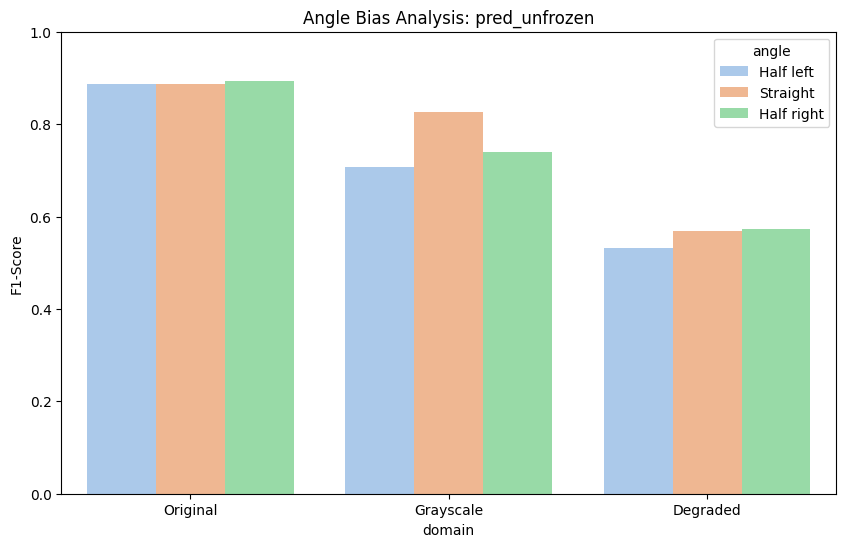

In [52]:
plot_angle_bias(res_df, "pred_unfrozen")

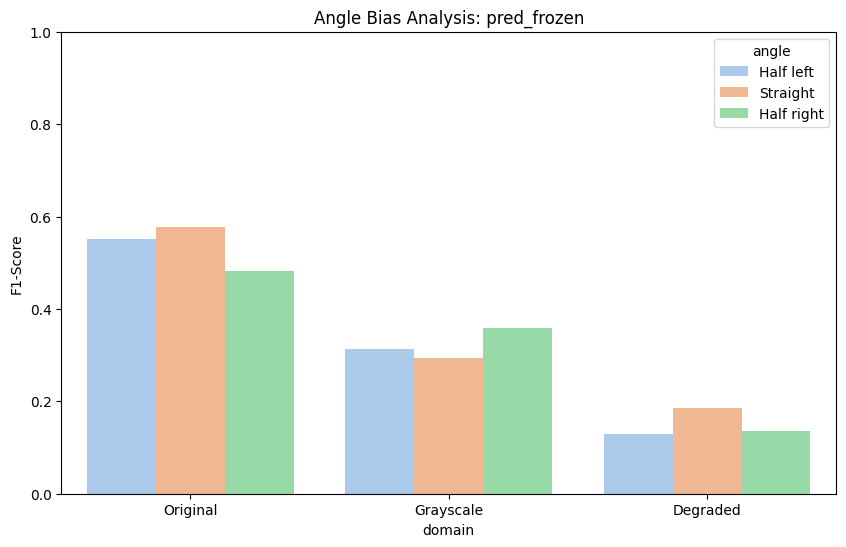

In [53]:
plot_angle_bias(res_df, "pred_frozen")

In [60]:
res_df['emotion'] = res_df['file'].apply(lambda x: x[9:11])


In [61]:
def plot_emotion_bias(df, model_col):
    bias_df = (
        df.groupby(["domain", "emotion"])
        .apply(lambda x: f1_score(x["true_idx"], x[model_col], average="macro"))
        .reset_index(name="F1-Score")
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=bias_df, 
        x="domain", 
        y="F1-Score", 
        hue="emotion", 
        palette="pastel",
        order=["Original", "Grayscale", "Degraded"],
    )
    plt.title(f"Emotion Bias Analysis: {model_col}")
    plt.ylim(0, 1.0)
    plt.show()

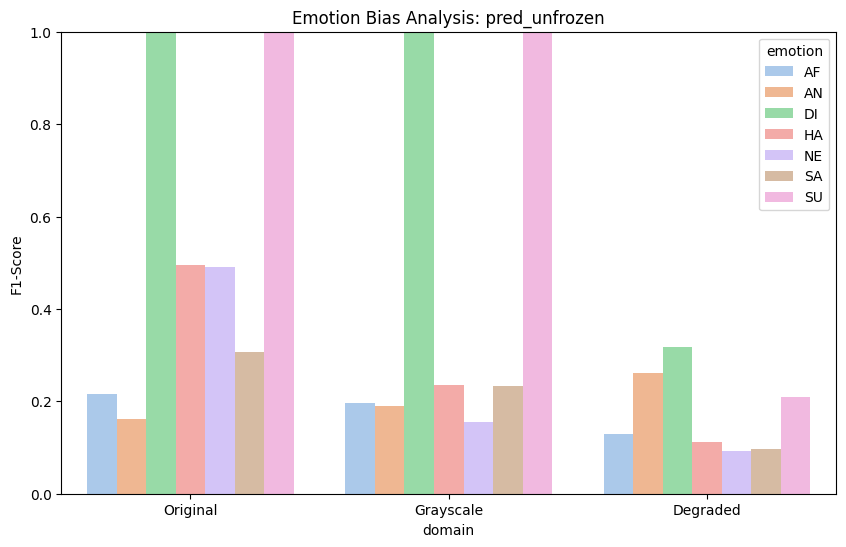

In [62]:
plot_emotion_bias(res_df, "pred_unfrozen")

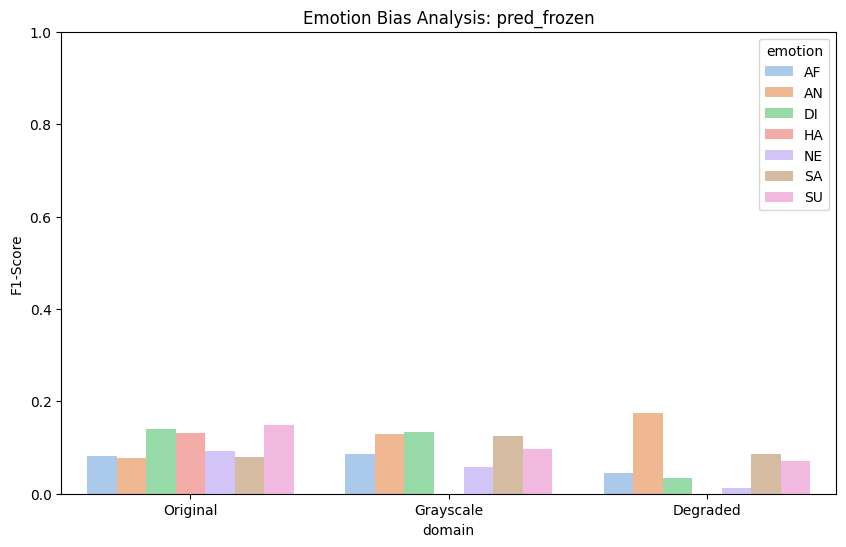

In [63]:
plot_emotion_bias(res_df, "pred_frozen")